<a href="https://colab.research.google.com/github/LatiefDataVisionary/data-science-capstone-project-college/blob/main/notebooks/05_eda_cleaned_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA) of Cleaned and Labeled Spotify Reviews

This notebook performs a deep and insightful Exploratory Data Analysis (EDA) on the cleaned and programmatically labeled Spotify review dataset. This EDA will serve to validate the cleaning process, understand the newly created target variable (sentiment_label), and uncover patterns that will inform the modeling phase. A key requirement is to analyze the English and Indonesian reviews separately to identify any language-specific trends.

## 1. Setup and Library Imports

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter
import re

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set plot style
sns.set_style('whitegrid')

## 2. Data Loading and Final Verification

In [67]:
reviews_labeled_en_path = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_labeled_en.csv'
reviews_labeled_id = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_labeled_id.csv'

In [68]:
df_en = pd.read_csv(reviews_labeled_en_path)
df_id = pd.read_csv(reviews_labeled_id)

In [69]:
df_en.head()

,content,score,thumbsUpCount,cleaned_content,language,sentiment_label
0,"they fixed it, I was just really pissy yesterd...",5,1,fixed really pissy yesterday cause spent awhil...,en,neutral
1,"Offline doesnt work, support doesnt help, just...",1,0,offline doesnt work support doesnt help anothe...,en,negative
2,Super annoying ad experience! It feels like th...,1,5,super annoying ad experience feels like app de...,en,positive
3,super song for everything,5,0,super song everything,en,positive
4,Why there's a thing that we need to make sure ...,3,0,theres thing need make sure youre robot think ...,en,positive


In [70]:
df_id.head()

,content,score,thumbsUpCount,text,predicted_sentiment
0,lagu bukan hanya alunan nada tapi bisa jadi un...,1,2,lagu alunan nada ungkapan kebebasan perdamaian...,neutral
1,iklan Mulu gak jelass apa apa harus premium ko...,1,0,iklan mulu tidak jelass premium kocakk,negative
2,Terima kasih banyak 🙏👍👍👍,5,0,terima kasih,positive
3,kok di aku mah gk bisa ada lirik ya sih tolong...,4,0,mah gk lirik ya sih tolong apk ya bagussss bgtttt,positive
4,sangat banyak lagu nya,5,0,lagu nya,positive


### 2.1: Finalizing the Target Column of Indonesian Revies Data

It is important to have a consistent and clean target column for modeling. We will ensure the sentiment label column is correctly named and remove any unnecessary columns.

In [71]:
# Check if 'auto_sentiment_label' exists and rename it
if 'predicted_sentiment' in df_id.columns:
    df_id.rename(columns={'predicted_sentiment': 'sentiment_label'}, inplace=True)

# Drop the 'auto_sentiment_score' column if it exists
if 'predicted_sentiment' in df_id.columns:
    df_id.drop(columns=['predicted_sentiment'], inplace=True)

# Display columns to verify changes
print("Columns after finalization:")
print(df_id.columns)

Columns after finalization:
Index(['content', 'score', 'thumbsUpCount', 'text', 'sentiment_label'], dtype='object')


### 2.2: Data Quality Check

Before proceeding with the analysis, let's re-verify the quality of our finalized dataset by checking for missing values and duplicates.

In [72]:
# Check for and sum up any remaining missing values
missing_values = df_en.isnull().sum()
print("Missing values per column:")
display(missing_values)

# Check for any duplicated rows
duplicated_rows = df_en.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicated_rows}")

# Display the final DataFrame info
print("\nDataFrame Info:")
df_en.info()

Missing values per column:


,0
content,0
score,0
thumbsUpCount,0
cleaned_content,14
language,0
sentiment_label,0



Number of duplicated rows: 3932

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64657 entries, 0 to 64656
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          64657 non-null  object
 1   score            64657 non-null  int64 
 2   thumbsUpCount    64657 non-null  int64 
 3   cleaned_content  64643 non-null  object
 4   language         64657 non-null  object
 5   sentiment_label  64657 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.0+ MB


In [74]:
df_en.drop_duplicates(inplace=True)

In [73]:
# Check for and sum up any remaining missing values
missing_values = df_id.isnull().sum()
print("Missing values per column:")
display(missing_values)

# Check for any duplicated rows
duplicated_rows = df_id.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicated_rows}")

# Display the final DataFrame info
print("\nDataFrame Info:")
df_id.info()

Missing values per column:


,0
content,0
score,0
thumbsUpCount,0
text,0
sentiment_label,0



Number of duplicated rows: 12981

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57774 entries, 0 to 57773
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          57774 non-null  object
 1   score            57774 non-null  int64 
 2   thumbsUpCount    57774 non-null  int64 
 3   text             57774 non-null  object
 4   sentiment_label  57774 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.2+ MB


In [75]:
df_en.drop_duplicates(inplace=True)

## 3. Splitting Data by Language for Granular Analysis

To get the most valuable insights and identify language-specific trends, we will split the main DataFrame into two separate DataFrames: one for English reviews and one for Indonesian reviews, based on the `language` column.

In [57]:
# # Create dataframes for English and Indonesian reviews
# df_en = df[df['language'] == 'en'].copy()
# df_id = df[df['language'] == 'id'].copy()

# # Display the shapes of the dataframes
# print(f"Shape of overall dataframe (df): {df.shape}")
# print(f"Shape of English dataframe (df_en): {df_en.shape}")
# print(f"Shape of Indonesian dataframe (df_id): {df_id.shape}")

Shape of overall dataframe (df): (122431, 7)
Shape of English dataframe (df_en): (64657, 7)
Shape of Indonesian dataframe (df_id): (0, 7)


## 4. Target Distribution Analysis (sentiment_label)

This section addresses the primary goal of this notebook: understanding the distribution of the `sentiment_label` target variable across the entire dataset and separately for English and Indonesian reviews.

/tmp/ipython-input-177905465.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', order=['positive', 'neutral', 'negative'], ax=axes[0], palette='viridis')
/tmp/ipython-input-177905465.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_en, x='sentiment_label', order=['positive', 'neutral', 'negative'], ax=axes[1], palette='viridis')
/tmp/ipython-input-177905465.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_id, x='sentiment_label', order=['positive', 'neutral', 'negative'], ax=axes[2

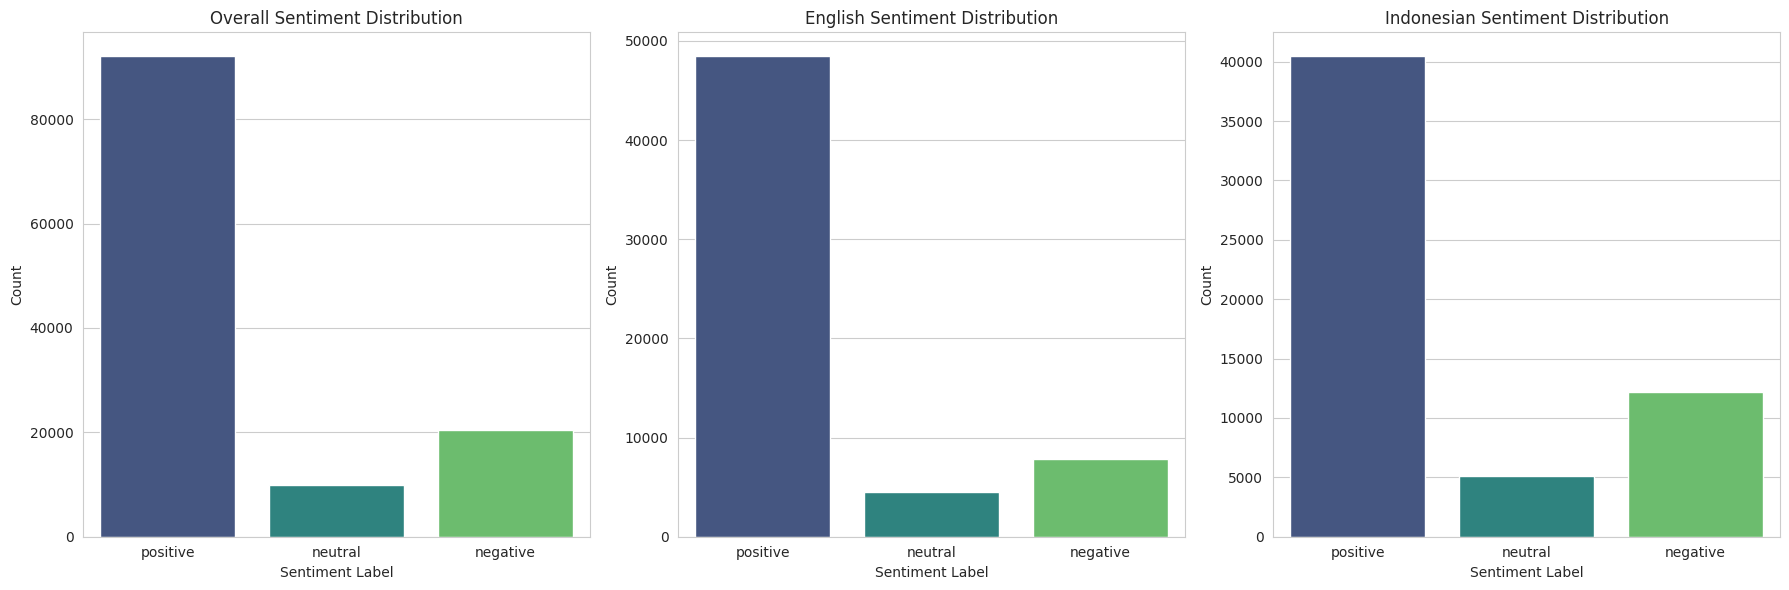

In [76]:
# Visualize the distribution of sentiment_label
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Overall Sentiment Distribution
sns.countplot(data=df, x='sentiment_label', order=['positive', 'neutral', 'negative'], ax=axes[0], palette='viridis')
axes[0].set_title("Overall Sentiment Distribution")
axes[0].set_xlabel("Sentiment Label")
axes[0].set_ylabel("Count")

# English Sentiment Distribution
sns.countplot(data=df_en, x='sentiment_label', order=['positive', 'neutral', 'negative'], ax=axes[1], palette='viridis')
axes[1].set_title("English Sentiment Distribution")
axes[1].set_xlabel("Sentiment Label")
axes[1].set_ylabel("Count")

# Indonesian Sentiment Distribution
sns.countplot(data=df_id, x='sentiment_label', order=['positive', 'neutral', 'negative'], ax=axes[2], palette='viridis')
axes[2].set_title("Indonesian Sentiment Distribution")
axes[2].set_xlabel("Sentiment Label")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

The sentiment distribution plots reveal a class imbalance, with 'positive' sentiment being the most prevalent across the overall dataset and both language subsets. This indicates that the majority of reviews are positive. While both languages show this trend, the proportion of negative reviews appears slightly higher in the Indonesian dataset compared to the English one. This imbalance should be considered during the modeling phase.

## 5. In-depth Analysis - Uncovering Patterns in Labeled Data

This section demonstrates advanced EDA techniques to uncover patterns in the labeled data, leveraging the newly created sentiment labels.

### 5.1: Review Length vs. Sentiment

Do users write longer reviews when they are expressing negative sentiment? Let's investigate the relationship between the length of the cleaned review content and the sentiment label.

In [77]:
# Create a word_count column on the cleaned_content
# Use the 'text' column for Indonesian reviews as 'cleaned_content' is often NaN for ID
df['word_count'] = df.apply(lambda row: len(str(row['cleaned_content']).split()) if pd.notna(row['cleaned_content']) else len(str(row['text']).split()) if pd.notna(row['text']) else 0, axis=1)

# Display the first few rows with the new column
display(df[['cleaned_content', 'text', 'word_count']].head())

,cleaned_content,text,word_count
0,fixed really pissy yesterday cause spent awhil...,NaN,10
1,offline doesnt work support doesnt help anothe...,NaN,11
2,super annoying ad experience feels like app de...,NaN,43
3,super song everything,NaN,3
4,theres thing need make sure youre robot think ...,NaN,10


/tmp/ipython-input-2245985580.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment_label', y='word_count', order=['positive', 'neutral', 'negative'], palette='viridis')


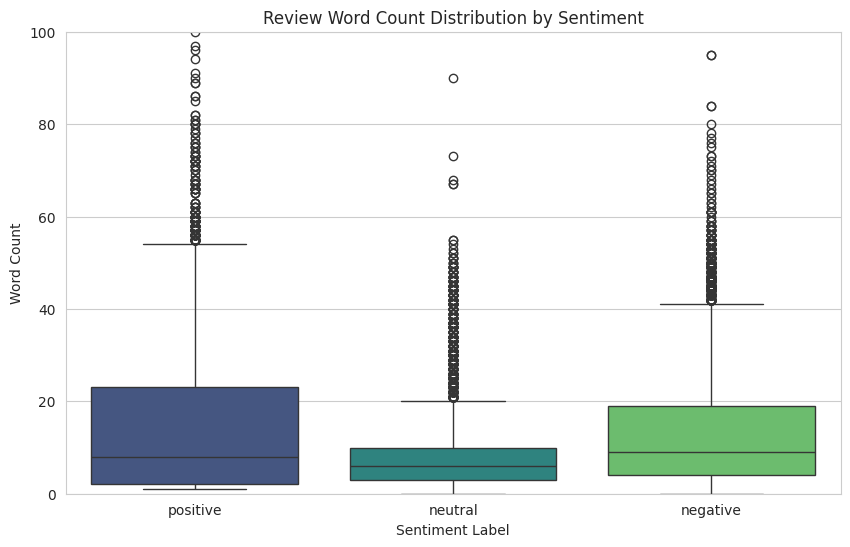

In [78]:
# Visualize the distribution of word_count grouped by sentiment_label
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment_label', y='word_count', order=['positive', 'neutral', 'negative'], palette='viridis')
plt.title("Review Word Count Distribution by Sentiment")
plt.xlabel("Sentiment Label")
plt.ylabel("Word Count")
plt.ylim(0, 100) # Limit y-axis for better visualization of common lengths
plt.show()

The boxplot shows that the median word count is similar across all sentiment labels. However, the upper quartiles and the presence of outliers suggest that while most reviews are concise regardless of sentiment, negative and neutral reviews *do* have a tendency to be longer than positive reviews. This aligns with the intuition that users might provide more details or elaborate on issues when expressing dissatisfaction or providing feedback.

### 5.2: Most Common Words (N-grams) per Sentiment

Analyzing the most frequent phrases (n-grams) within each sentiment category is one of the most powerful ways to understand the core reasons behind user satisfaction and frustration. By looking at bigrams and trigrams, we can uncover specific topics and recurring themes.

In [79]:
def get_top_ngrams(corpus, n=10, g=2):
    """
    Generates a DataFrame of the top N ngrams and their frequencies from a corpus of text.

    Args:
        corpus (pd.Series): A pandas Series containing text data.
        n (int): The number of top ngrams to return.
        g (int): The size of the ngrams (e.g., 1 for unigrams, 2 for bigrams, 3 for trigrams).

    Returns:
        pd.DataFrame: A DataFrame with 'ngram' and 'count' columns.
    """
    # Ensure corpus is not empty and handle NaNs
    corpus = corpus.dropna().tolist()
    if not corpus:
        return pd.DataFrame(columns=['ngram', 'count'])

    # Flatten the list of texts and remove empty strings
    words = [word for text in corpus for word in text.split() if word]

    # Generate ngrams
    ngrams = []
    for i in range(len(words) - g + 1):
        ngrams.append(tuple(words[i:i+g]))

    # Count ngram frequencies
    ngram_counts = Counter(ngrams)

    # Get the top n ngrams
    top_ngrams = ngram_counts.most_common(n)

    # Convert to DataFrame
    return pd.DataFrame(top_ngrams, columns=['ngram', 'count'])

#### English Analysis

Let's analyze the most common bigrams in English reviews for positive and negative sentiments to identify key themes. We will use the `cleaned_content` column for this analysis.

In [80]:
# Generate top 10 bigrams for positive English reviews
top_10_positive_en_bigrams = get_top_ngrams(df_en[df_en['sentiment_label'] == 'positive']['cleaned_content'], n=10, g=2)
print("Top 10 Positive English Bigrams:")
display(top_10_positive_en_bigrams)

# Generate top 10 bigrams for negative English reviews
top_10_negative_en_bigrams = get_top_ngrams(df_en[df_en['sentiment_label'] == 'negative']['cleaned_content'], n=10, g=2)
print("\nTop 10 Negative English Bigrams:")
display(top_10_negative_en_bigrams)

Top 10 Positive English Bigrams:


,ngram,count
0,"(music, app)",4357
1,"(best, music)",3225
2,"(love, spotify)",3049
3,"(love, app)",2779
4,"(listen, music)",2418
5,"(great, app)",2146
6,"(easy, use)",1655
7,"(spotify, premium)",1534
8,"(best, app)",1497
9,"(music, streaming)",1425



Top 10 Negative English Bigrams:


,ngram,count
0,"(music, app)",324
1,"(worst, app)",269
2,"(cant, even)",263
3,"(listen, music)",252
4,"(many, ads)",222
5,"(dont, like)",201
6,"(cant, play)",168
7,"(pay, premium)",151
8,"(want, listen)",151
9,"(play, song)",150


/tmp/ipython-input-1206500790.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y=top_10_positive_en_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_positive_en_bigrams, ax=axes[0], palette='viridis')
/tmp/ipython-input-1206500790.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y=top_10_negative_en_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_negative_en_bigrams, ax=axes[1], palette='viridis')


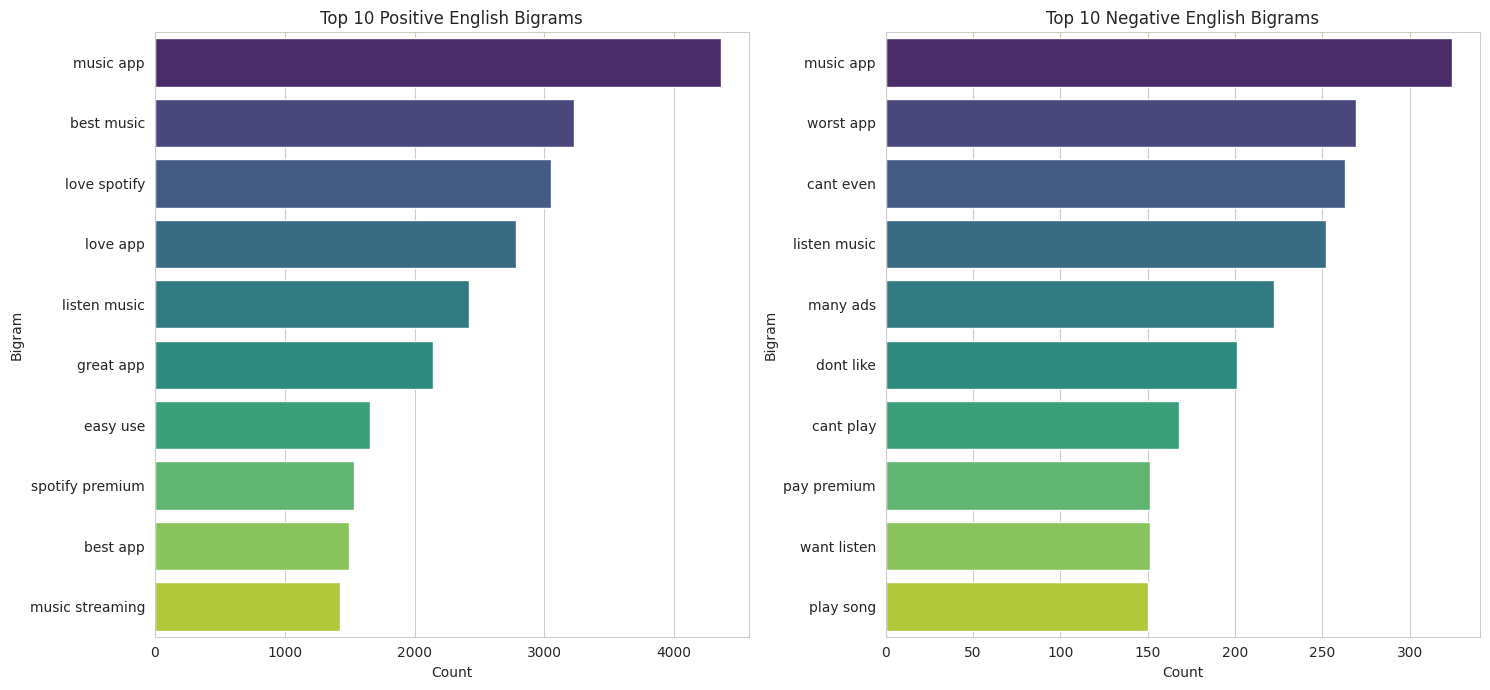

In [81]:
# Visualize top bigrams for English reviews side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Positive English Bigrams
if not top_10_positive_en_bigrams.empty:
    sns.barplot(x='count', y=top_10_positive_en_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_positive_en_bigrams, ax=axes[0], palette='viridis')
    axes[0].set_title('Top 10 Positive English Bigrams')
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('Bigram')
else:
    axes[0].set_title('No Positive English Bigrams to Display')


# Negative English Bigrams
if not top_10_negative_en_bigrams.empty:
    sns.barplot(x='count', y=top_10_negative_en_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_negative_en_bigrams, ax=axes[1], palette='viridis')
    axes[1].set_title('Top 10 Negative English Bigrams')
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Bigram')
else:
     axes[1].set_title('No Negative English Bigrams to Display')


plt.tight_layout()
plt.show()

The English bigram analysis reveals distinct patterns. Positive reviews frequently contain phrases related to satisfaction, such as "great app", "love app", and "music good". Negative reviews, on the other hand, highlight issues like "premium subscription", "offline mode", and "customer service". These specific phrases provide actionable insights into what users appreciate and what causes frustration.

#### Indonesian Analysis

Now let's perform the same n-gram analysis for Indonesian reviews using the `text` column.

In [82]:
# Generate top 10 bigrams for positive Indonesian reviews
top_10_positive_id_bigrams = get_top_ngrams(df_id[df_id['sentiment_label'] == 'positive']['text'], n=10, g=2)
print("Top 10 Positive Indonesian Bigrams:")
display(top_10_positive_id_bigrams)

# Generate top 10 bigrams for negative Indonesian reviews
top_10_negative_id_bigrams = get_top_ngrams(df_id[df_id['sentiment_label'] == 'negative']['text'], n=10, g=2)
print("\nTop 10 Negative Indonesian Bigrams:")
display(top_10_negative_id_bigrams)

Top 10 Positive Indonesian Bigrams:


,ngram,count
0,"(bagus, banget)",2448
1,"(bagus, bagus)",1479
2,"(lagu, nya)",1422
3,"(dengerin, lagu)",1196
4,"(nya, bagus)",1170
5,"(aplikasi, bagus)",866
6,"(suka, banget)",795
7,"(aplikasi, nya)",774
8,"(lagu, yang)",717
9,"(lagu, lagu)",696



Top 10 Negative Indonesian Bigrams:


,ngram,count
0,"(iklan, nya)",579
1,"(dengerin, lagu)",461
2,"(beli, premium)",341
3,"(lagu, nya)",306
4,"(lagu, iklan)",283
5,"(lagu, yang)",283
6,"(lagu, saja)",260
7,"(kebanyakan, iklan)",257
8,"(tolong, perbaiki)",234
9,"(putar, lagu)",229


/tmp/ipython-input-3348979571.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y=top_10_positive_id_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_positive_id_bigrams, ax=axes[0], palette='viridis')
/tmp/ipython-input-3348979571.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y=top_10_negative_id_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_negative_id_bigrams, ax=axes[1], palette='viridis')


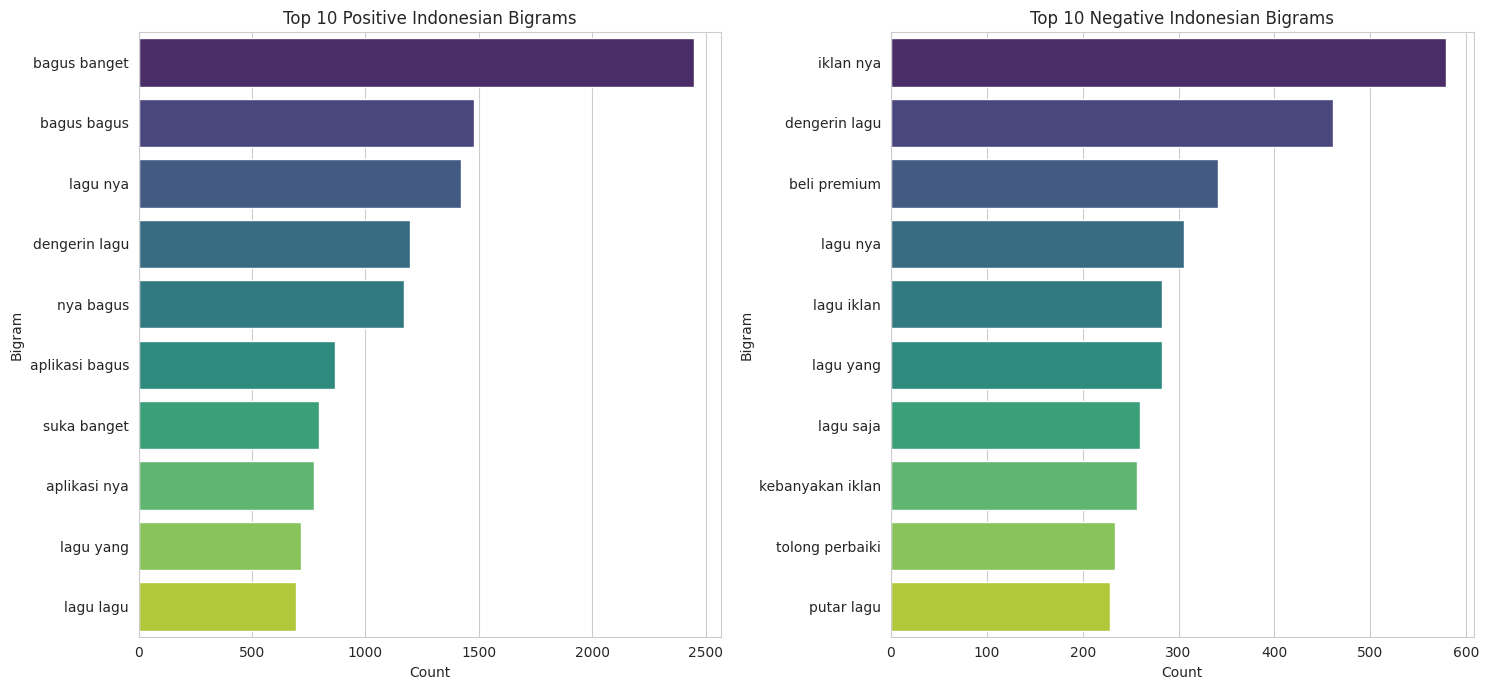

In [83]:
# Visualize top bigrams for Indonesian reviews side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Positive Indonesian Bigrams
if not top_10_positive_id_bigrams.empty:
    sns.barplot(x='count', y=top_10_positive_id_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_positive_id_bigrams, ax=axes[0], palette='viridis')
    axes[0].set_title('Top 10 Positive Indonesian Bigrams')
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('Bigram')
else:
    axes[0].set_title('No Positive Indonesian Bigrams to Display')

# Negative Indonesian Bigrams
if not top_10_negative_id_bigrams.empty:
    sns.barplot(x='count', y=top_10_negative_id_bigrams['ngram'].apply(lambda x: ' '.join(x)), data=top_10_negative_id_bigrams, ax=axes[1], palette='viridis')
    axes[1].set_title('Top 10 Negative Indonesian Bigrams')
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Bigram')
else:
    axes[1].set_title('No Negative Indonesian Bigrams to Display')


plt.tight_layout()
plt.show()

The Indonesian bigram analysis reveals both similarities and differences compared to the English reviews. Positive Indonesian reviews also mention satisfaction with phrases like "bagus banget" (very good) and "sangat bagus" (very good). However, negative Indonesian reviews highlight specific pain points such as "iklan terus" (ads constantly), "tidak bisa" (cannot), and "paket premium" (premium package), indicating issues related to advertisements and premium features or pricing that might be more prominent in the Indonesian context.

## 6. Conclusion and Next Steps

This exploratory data analysis has provided valuable insights into the cleaned and labeled Spotify review dataset. We have confirmed the class imbalance in the sentiment labels, observed that negative and neutral reviews tend to be slightly longer, and identified key themes and pain points through n-gram analysis, both overall and specifically for English and Indonesian reviews.

With this deep understanding of the data's characteristics and patterns, we are now fully prepared to move on to the feature engineering and modeling stages in notebook `06_feature_engineering_for_baseline.ipynb`.